In [4]:
'''How detection efficiency impacts the fidelity of the resultant state 
after several photon catalysis steps'''
import cmath, random, numpy
import functools
import  matplotlib.pyplot as plt
import sys
import os
import math
from qutip import*

from sympy import*
#from sympsi import*
from scipy import optimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex
import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial    

In [5]:
"""Define the operators for MZI - we will deal in Heisenberg """
T = Symbol('T')
xvec = np.arange(-30.,30.)*5./40
X,Y = np.meshgrid(xvec, xvec)  ##Some plotting params
N_dim = 35##Dimenstion of the Hilbert spac

a1 = destroy(N_dim) ##This is for single-photon field
a2 = destroy(N_dim) ##for coherent field
a3 = destroy(N_dim) ##for vacuum field
def n_choose_k(n,k):
    return factorial(n)/(factorial(n-k)*factorial(k))
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_operator_filtering(a1, a2, k):
    theta_k = np.arctan(1/np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm()
def SSV_plus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)+displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def SSV_minus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)-displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def pnr_resolution_detector(eta, click, n_truc):
    pi_n = 0;
    l = np.arange(click,n_truc)
    for i in l:
        pi_n +=  n_choose_k(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(N_dim,i)*fock(N_dim,i).dag()
        #print("The final Povm element is: ", pi_0)
    return Qobj(pi_n)
def Fock_Filter_povm(in1,in2,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in1,in2);
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
        
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def Fock_Filter_prob(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered=Rho*Projector
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered

def fid(state1,state2):
    F=np.absolute((state1.sqrtm()*state2*state1.sqrtm()).sqrtm().tr())
    return F

In [6]:
#Variable definitions:
#delta = initial coherent state amplitude
# refl(1-3)= beamsplitter r^2 values at each step
# n(1-3) = number of photons detected at each detector
# beta = amplitude of final dispalcement to displace the state back
#alpha = amplitude of SSV state to be compared with.  Note, here
#this can be related to cat state amplitude by amp_cat=alpha/(Cosh[sq]-Sinh[sq])
# sq = the 'r' value, or squeezing parameter. This is the negative of the mathematica results.

'''Three-step check: P -> 0.00179605, 0.9836, r[3.] -> 0.520135, r[2.] -> 0.490869, 
 r[1.] -> 0.637566, \[Alpha] -> 1.349, 
 sq -> -0.476595, \[Beta] -> 2.03846, delta -> 3.53709, n1 -> 5, 
 n2 -> 2, n3 -> 1}'''

refl1=0.637566**2; refl2=0.490869**2; refl3=0.520135**2;
delta=3.53709; beta=2.03846; sq=0.476595; alpha=1.349; n1=5;n2=2;n3=1;

#refl1=1/2; refl2=1/2; refl3=2/3;
#delta=np.sqrt(14); beta=np.sqrt(19/16); sq=0.476595; alpha=1.4; n1=5;n2=3;n3=1;
'''Two-step, check: {
 
 {P -> 0.0152557, 0.999653, r[2.] -> 0.852986, 
  r[1.] -> 0.603152, \[Alpha] -> 0.901576, 
  sq -> -0.224664, \[Beta] -> 0.5, delta -> 1.19655, n1 -> 1, 
  n2 -> 2}
}'''
refl1=0.603152**2; refl2=0.852986**2; delta=1.19655; beta=0.5; sq=0.224664; alpha=0.901576; n1=1;n2=2

'''Four-step check: r[4.] = 0.42134; r[3.] = 0.69684; r[2.] = 0.55398; 
r[1.] = .576813; \[Delta] = 4.6621868; n[4.] = 1; n[3.] = 2; 
n[2.] = 4; n[1.] = 6;
sq= -0.51, alpha= 1.59, beta= 2.08625'''

refl1= .576813**2; refl2=0.55398**2; refl3=0.69684**2;refl4=0.42134**2;
delta=4.6621868; beta=2.08625; sq=0.476595; alpha=1.59; n1=6;n2=4;n3=2;n4=1;

In [7]:
#TEST
#Make a loop to take max values after iterating and put into a single array
End=np.zeros(10);
for i in range(10):
    temp=np.zeros(31);
    for j in range(31):
        x=j/10+i;
        temp[j]=x;
    End[i]=max(temp);

In [8]:
End

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

BS has reflectivity 0.332713236969  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.3068938404  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.48558598560000005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.1775273956  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.332713236969  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.3068938404  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.48558598560000005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has e

BS has reflectivity 0.3068938404  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.86
BS has reflectivity 0.48558598560000005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.86
BS has reflectivity 0.1775273956  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.86
BS has reflectivity 0.332713236969  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.85
BS has reflectivity 0.3068938404  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.85
BS has reflectivity 0.48558598560000005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.85
BS has reflectivity 0.1775273956  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has

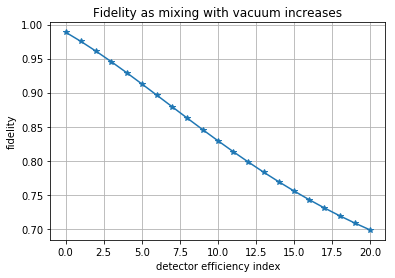

In [9]:
'''Four-step check: r[4.] = 0.42134; r[3.] = 0.69684; r[2.] = 0.55398; 
r[1.] = .576813; \[Delta] = 4.6621868; n[4.] = 1; n[3.] = 2; 
n[2.] = 4; n[1.] = 6;
sq= -0.51, alpha= 1.59, beta= 2.08625'''
def mixture(purity):
    state=purity*ket2dm(fock(N_dim,1))+(1-purity)*ket2dm(fock(N_dim,0))
    return state

eta=1;
refl1= .576813**2; refl2=0.55398**2; refl3=0.69684**2;refl4=0.42134**2;
delta=4.6621868; beta=2.08625; sq=0.476595; alpha=1.59; n1=6;n2=4;n3=2;n4=1;

ssv=SSV_plus(sq,alpha)

four_step=np.zeros(21)
for k in range(21):
    first=Fock_Filter_povm(ket2dm(coherent(N_dim,delta)),ket2dm(fock(N_dim,1)),refl1,n1,eta-0.01*k,N_dim)
    second=Fock_Filter_povm(first,ket2dm(fock(N_dim,1)),refl2,n2,eta-0.01*k,N_dim);
    third=Fock_Filter_povm(second,ket2dm(fock(N_dim,1)),refl3,n3,eta-0.01*k,N_dim);
    fourth=Fock_Filter_povm(third,ket2dm(fock(N_dim,1)),refl4,n4,eta-0.01*k,N_dim);
    F=np.zeros(60)
    for i in range(60):
        final_state=D(fourth,beta*(-1)-0.3+0.01*i)
        F[i]=fid(final_state,ssv)
    four_step[k]=max(F)
    
plt.plot(range(21),four_step,'-*')        
plt.grid()
plt.xlabel('detector efficiency index')
plt.ylabel('fidelity')
#set_xlim([40, 60])
plt.title('Fidelity as mixing with vacuum increases')
plt.show()



BS has reflectivity 0.406490404356  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.240952375161  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.270540418225  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.406490404356  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.240952375161  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.270540418225  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.406490404356  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has effi

BS has reflectivity 0.406490404356  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.81
BS has reflectivity 0.240952375161  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.81
BS has reflectivity 0.270540418225  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.81
BS has reflectivity 0.406490404356  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.8
BS has reflectivity 0.240952375161  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.8
BS has reflectivity 0.270540418225  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.8


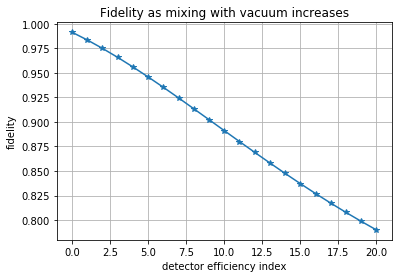

In [10]:
'''Three-step check: P -> 0.00179605, 0.9836, r[3.] -> 0.520135, r[2.] -> 0.490869, 
 r[1.] -> 0.637566, \[Alpha] -> 1.349, 
 sq -> -0.476595, \[Beta] -> 2.03846, delta -> 3.53709, n1 -> 5, 
 n2 -> 2, n3 -> 1}'''

refl1=0.637566**2; refl2=0.490869**2; refl3=0.520135**2;
delta=3.53709; beta=2.03846; sq=0.476595; alpha=1.349; n1=5;n2=2;n3=1;

ssv=SSV_minus(sq,alpha)

three_step=np.zeros(21)
for k in range(21):
    first=Fock_Filter_povm(ket2dm(coherent(N_dim,delta)),ket2dm(fock(N_dim,1)),refl1,n1,eta-0.01*k,N_dim)
    second=Fock_Filter_povm(first,ket2dm(fock(N_dim,1)),refl2,n2,eta-0.01*k,N_dim);
    third=Fock_Filter_povm(second,ket2dm(fock(N_dim,1)),refl3,n3,eta-0.01*k,N_dim);
    F=np.zeros(60)
    for i in range(60):
        final_state=D(third,beta*(-1)-0.3+0.01*i)
        F[i]=fid(final_state,ssv)
    three_step[k]=max(F)
    
plt.plot(range(21),three_step,'-*')        
plt.grid()
plt.xlabel('detector efficiency index')
plt.ylabel('fidelity')
#set_xlim([40, 60])
plt.title('Fidelity as mixing with vacuum increases')
plt.show()


BS has reflectivity 0.36379233510400005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.7275851161960001  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 1.0
BS has reflectivity 0.36379233510400005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.7275851161960001  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.99
BS has reflectivity 0.36379233510400005  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.98
BS has reflectivity 0.7275851161960001  and I am detecting the | <function num at 0x00000272EA6938C8> > state, where my detector has efficiency 0.98
BS has reflectivity 0.36379233510400005  and I am detecting the | <function num at 0x00000272EA6938C8> > 

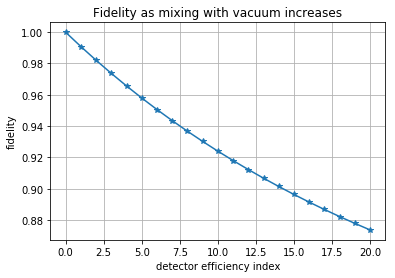

In [11]:
'''Two-step, check: {
 
 {P -> 0.0152557, 0.999653, r[2.] -> 0.852986, 
  r[1.] -> 0.603152, \[Alpha] -> 0.901576, 
  sq -> -0.224664, \[Beta] -> 0.5, delta -> 1.19655, n1 -> 1, 
  n2 -> 2}
}'''
refl1=0.603152**2; refl2=0.852986**2; delta=1.19655; beta=0.5; sq=0.224664; alpha=0.901576; n1=1;n2=2

ssv=SSV_plus(sq,alpha)

two_step=np.zeros(21)
for k in range(21):
    first=Fock_Filter_povm(ket2dm(coherent(N_dim,delta)),ket2dm(fock(N_dim,1)),refl1,n1,eta-0.01*k,N_dim)
    second=Fock_Filter_povm(first,ket2dm(fock(N_dim,1)),refl2,n2,eta-0.01*k,N_dim);
    F=np.zeros(60)
    for i in range(60):
        final_state=D(second,beta*(-1)-0.3+0.01*i)
        F[i]=fid(final_state,ssv)
    two_step[k]=max(F)
    
plt.plot(range(21),two_step,'-*')        
plt.grid()
plt.xlabel('detector efficiency index')
plt.ylabel('fidelity')
#set_xlim([40, 60])
plt.title('Fidelity as mixing with vacuum increases')
plt.show()


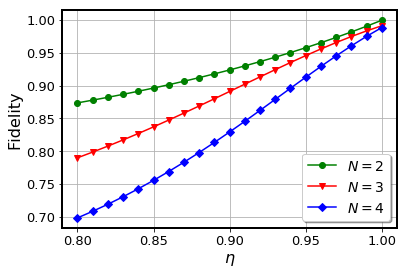

In [20]:
from pylab import *
rc('axes', linewidth=2)
fontsize=14
array=np.arange(1,.79,-.01)
#array=[1,0.95,0.9,0.85,0.8]
plt.plot(array,two_step,'g-o',array,three_step,'-rv',array,four_step,'b-D')        
plt.grid()
plt.legend((r'$N=2$', r'$N=3$',r'$N=4$'),
           loc='lower right', shadow=True, fontsize=14)
plt.xlabel(r'$\eta$',fontsize=16)
plt.ylabel('Fidelity',fontsize=16)
#set_xlim([40, 60])
#plt.title('Fidelity of filtered state with displaced single photon', fontsize=16)
plt.tick_params(axis='both', labelsize=13)

plt.show()

In [14]:
two_step

array([0.99982773, 0.99069582, 0.98195552, 0.97358903, 0.96557464,
       0.95789583, 0.95053798, 0.94348408, 0.93671924, 0.93023164,
       0.92400345, 0.91802701, 0.91228881, 0.90677755, 0.90148548,
       0.89640018, 0.89151312, 0.88681491, 0.88229976, 0.87795554,
       0.87377933])

In [15]:
three_step

array([0.99141659, 0.98355323, 0.97497211, 0.96580375, 0.95605709,
       0.94586302, 0.93532703, 0.92449565, 0.91346164, 0.90235847,
       0.89120544, 0.88007526, 0.86906515, 0.85822864, 0.84758378,
       0.83718175, 0.82707627, 0.81729924, 0.80784724, 0.79874196,
       0.78999414])

In [16]:
four_step

array([0.98867933, 0.97525847, 0.96076169, 0.94543371, 0.92940169,
       0.91287004, 0.89610661, 0.87921216, 0.86235925, 0.84571169,
       0.82940623, 0.81349495, 0.79810169, 0.78329702, 0.76913131,
       0.7556173 , 0.74277801, 0.73062461, 0.71918904, 0.70843641,
       0.69835126])

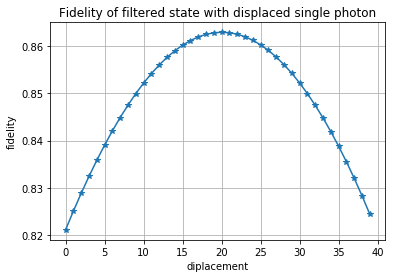

In [5]:
F=np.zeros(40)
for i in range(40):
    final_state=D(fourth,beta*(-1)-0.2+0.01*i)
    F[i]=fid(final_state,ssv)
plt.plot(range(40),F,'-*')        
plt.grid()
plt.xlabel('diplacement')
plt.ylabel('fidelity')
#set_xlim([40, 60])
plt.title('Fidelity of filtered state with displaced single photon')
plt.show()